In [1]:
from langchain import document_loaders as dl
from langchain import embeddings
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain import text_splitter as ts
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_ollama import OllamaEmbeddings, ChatOllama
from langchain_core.tools import tool
from langchain_core.tools.retriever import create_retriever_tool
import torch
import faiss
from typing import Annotated, Sequence, Literal, List
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph.message import add_messages
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from IPython.display import Image, display
import os
from langchain import hub
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode, create_react_agent
import json
import numexpr
import math
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
dir_path = 'C:/Users/Carlini/OneDrive - Alma Mater Studiorum Università di Bologna/Articoli/MS'

loader = dl.DirectoryLoader(dir_path, glob='*.pdf', loader_cls=dl.PyPDFLoader, show_progress=True)
doc = loader.load()

text_splitter = ts.RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

all_splits = text_splitter.split_documents(doc)

  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 35/35 [00:28<00:00,  1.22it/s]


In [3]:
embeddings = OllamaEmbeddings(model="mxbai-embed-large")

index = faiss.IndexFlatL2(len(embeddings.embed_query("Hello world!")))

vector_store = FAISS(embedding_function=embeddings, index=index, docstore=InMemoryDocstore(), index_to_docstore_id={})

_ = vector_store.add_documents(all_splits)


In [4]:
retriever = vector_store.as_retriever(search_kwargs={"k": 5})

retriever_tool = create_retriever_tool(
    retriever,
    "retriever",
    "Search documents in a vectorstore and return the most relevant based on a query",
)

@tool
def calculator(expression: str) -> str:
    """Calculate expression using Python's numexpr library.

    Expression should be a single line mathematical expression
    that solves the problem.

    Examples:
        "37593 * 67" for "37593 times 67"
        "37593**5" for "37593^5"
    """
    local_dict = {"pi": math.pi, "e": math.e}
    return str(
        numexpr.evaluate(
            expression.strip(),
            global_dict={},  # restrict access to globals
            local_dict=local_dict,  # add common mathematical functions
        )
    )

tools = [retriever_tool, calculator]

In [5]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    user_question: str
    documents: List[str]

In [6]:
memory = MemorySaver()

In [7]:
def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOllama(model="llama3.2:3b-instruct-fp16", temperature=0)

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


### Nodes


def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    user_question = messages[-1].content
    model = ChatOllama(model="llama3-groq-tool-use:8b-fp16", temperature=0)
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response], "user_question": user_question}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content
    user_question = state["user_question"]

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {user_question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOllama(model="llama3.2:3b-instruct-fp16", temperature=0)
    response = model.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = state["user_question"]
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOllama(model="llama3.2:3b-instruct-fp16", temperature=0)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [8]:
config = {"configurable": {"thread_id": "abc123"}}

In [9]:
model = ChatOllama(model="llama3-groq-tool-use:8b-fp16", temperature=0)

agent_executor = create_react_agent(model, tools, checkpointer=memory)

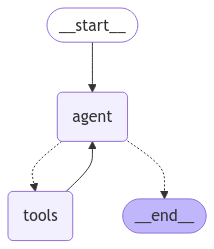

In [10]:
try:
    display(Image(agent_executor.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [13]:
model_with_tools = model.bind_tools(tools)

out = model_with_tools.invoke([HumanMessage(content="Retrieve information about multiple sclerosis treatments")])

out.tool_calls[0]

{'name': 'retriever',
 'args': {'query': 'multiple sclerosis treatments'},
 'id': '9aaab786-d31c-4a40-9ff2-bc046eccba36',
 'type': 'tool_call'}

In [115]:
import pprint

inputs = {
    "messages": [
        ("user", "Hi llama how are you?"),
    ]
}
for output in agent_executor.stream(inputs, config=config):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content="I'm doing well, thank you! How can I assist you today?", additional_kwargs={}, response_metadata={'model': 'llama3-groq-tool-use:8b-fp16', 'created_at': '2024-12-09T14:27:11.4413267Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3824093400, 'load_duration': 2971604800, 'prompt_eval_count': 420, 'prompt_eval_duration': 155000000, 'eval_count': 16, 'eval_duration': 395000000, 'message': Message(role='assistant', content="I'm doing well, thank you! How can I assist you today?", images=None, tool_calls=None)}, id='run-5998c4b2-51a1-4fd1-bd6c-6f058397af8c-0', usage_metadata={'input_tokens': 420, 'output_tokens': 16, 'total_tokens': 436})]}
'\n---\n'


In [116]:
import pprint

inputs = {
    "messages": [
        ("user", "Could you help me with some documents?"),
    ]
}
for output in agent_executor.stream(inputs, config=config):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='Of course! What kind of documents are you looking for?', additional_kwargs={}, response_metadata={'model': 'llama3-groq-tool-use:8b-fp16', 'created_at': '2024-12-09T14:27:17.5065405Z', 'done': True, 'done_reason': 'stop', 'total_duration': 656965300, 'load_duration': 15294600, 'prompt_eval_count': 453, 'prompt_eval_duration': 309000000, 'eval_count': 13, 'eval_duration': 327000000, 'message': Message(role='assistant', content='Of course! What kind of documents are you looking for?', images=None, tool_calls=None)}, id='run-d27c72a4-df15-43d2-aec6-289d3f080bc9-0', usage_metadata={'input_tokens': 453, 'output_tokens': 13, 'total_tokens': 466})]}
'\n---\n'


In [118]:
import pprint

inputs = {
    "messages": [
        ("user", "Yes, tell me more about the available treatments"),
    ]
}
for output in agent_executor.stream(inputs, config=config):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3-groq-tool-use:8b-fp16', 'created_at': '2024-12-09T14:28:22.2028505Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1240984900, 'load_duration': 14316700, 'prompt_eval_count': 1781, 'prompt_eval_duration': 351000000, 'eval_count': 32, 'eval_duration': 847000000, 'message': Message(role='assistant', content='', images=None, tool_calls=[ToolCall(function=Function(name='retriever', arguments={'query': 'treatments for multiple sclerosis'}))])}, id='run-70aa5225-e4b4-4f72-adb8-2aa175a8631a-0', tool_calls=[{'name': 'retriever', 'args': {'query': 'treatments for multiple sclerosis'}, 'id': '2bd06109-8eff-425d-abee-356e54b72255', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1781, 'output_tokens': 32, 'total_tokens': 1813})]}
'\n---\n'
"Output from node 'tools':"
'---'
{ 'messages': [ ToolMessage(content='Abstract \n \nIn this article, I present th

In [123]:
import pprint

inputs = {
    "messages": [
        ("user", "Divide that by 4"),
    ]
}
for output in agent_executor.stream(inputs, config=config):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3-groq-tool-use:8b-fp16', 'created_at': '2024-12-09T14:55:32.2723442Z', 'done': True, 'done_reason': 'stop', 'total_duration': 899697400, 'load_duration': 15393100, 'prompt_eval_count': 2016, 'prompt_eval_duration': 224000000, 'eval_count': 23, 'eval_duration': 639000000, 'message': Message(role='assistant', content='', images=None, tool_calls=[ToolCall(function=Function(name='calculator', arguments={'expression': '16.5 / 4'}))])}, id='run-a363a938-2aac-44fa-9988-b9142a8a89d8-0', tool_calls=[{'name': 'calculator', 'args': {'expression': '16.5 / 4'}, 'id': '66534187-2b26-481e-b475-3b03901628d5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2016, 'output_tokens': 23, 'total_tokens': 2039})]}
'\n---\n'
"Output from node 'tools':"
'---'
{ 'messages': [ ToolMessage(content='4.125', name='calculator', id='fadabbae-39a2-43ae-a2f4-988fbb114668', tool_call_id

In [107]:
# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
tools_node = ToolNode(tools)
workflow.add_node("tools", tools_node)
# workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "tools",
        END: END,
    },
)

# Edges taken after the `action` node is called.
# workflow.add_conditional_edges(
#     "retrieve",
#     # Assess agent decision
#     grade_documents,
# )
workflow.add_conditional_edges("tools", "generate")
workflow.add_edge("tools", END)
# workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile(checkpointer=memory)
config = {"configurable": {"thread_id": "abc123"}}

TypeError: Expected a Runnable, callable or dict.Instead got an unsupported type: <class 'str'>

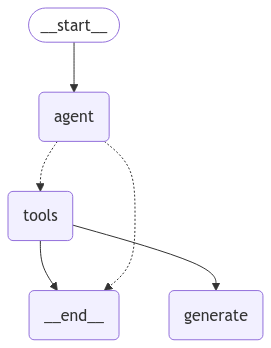

In [102]:
try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [103]:
import pprint

inputs = {
    "messages": [
        ("user", "Hi llama how are you?"),
    ]
}
for output in graph.stream(inputs, config=config):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content="I'm doing well, thank you! How can I assist you today?", additional_kwargs={}, response_metadata={'model': 'llama3-groq-tool-use:8b-fp16', 'created_at': '2024-12-09T12:17:44.124041Z', 'done': True, 'done_reason': 'stop', 'total_duration': 795489700, 'load_duration': 14565500, 'prompt_eval_count': 258, 'prompt_eval_duration': 361000000, 'eval_count': 16, 'eval_duration': 418000000, 'message': Message(role='assistant', content="I'm doing well, thank you! How can I assist you today?", images=None, tool_calls=None)}, id='run-354c87f8-7311-436a-bdf4-d29395e13740-0', usage_metadata={'input_tokens': 258, 'output_tokens': 16, 'total_tokens': 274})],
  'user_question': 'Hi llama how are you?'}
'\n---\n'


In [104]:
import pprint

inputs = {
    "messages": [
        ("user", "Could you help me with some documents?"),
    ]
}
for output in graph.stream(inputs, config=config):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='Of course! What kind of documents are you looking for?', additional_kwargs={}, response_metadata={'model': 'llama3-groq-tool-use:8b-fp16', 'created_at': '2024-12-09T12:17:44.8255367Z', 'done': True, 'done_reason': 'stop', 'total_duration': 363288000, 'load_duration': 14868700, 'prompt_eval_count': 291, 'prompt_eval_duration': 12000000, 'eval_count': 13, 'eval_duration': 335000000, 'message': Message(role='assistant', content='Of course! What kind of documents are you looking for?', images=None, tool_calls=None)}, id='run-d90aafcd-57e0-4980-b5fb-ae1b158f5cdd-0', usage_metadata={'input_tokens': 291, 'output_tokens': 13, 'total_tokens': 304})],
  'user_question': 'Could you help me with some documents?'}
'\n---\n'


In [105]:
import pprint

inputs = {
    "messages": [
        ("user", "what's 0.41 to the power of 3?"),
    ]
}
for output in graph.stream(inputs, config=config):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3-groq-tool-use:8b-fp16', 'created_at': '2024-12-09T12:17:50.4929641Z', 'done': True, 'done_reason': 'stop', 'total_duration': 830122800, 'load_duration': 14674100, 'prompt_eval_count': 326, 'prompt_eval_duration': 41000000, 'eval_count': 29, 'eval_duration': 772000000, 'message': Message(role='assistant', content='', images=None, tool_calls=[ToolCall(function=Function(name='calculator', arguments={'expression': '0.41**3'}))])}, id='run-1c0c5a8f-4790-4c4d-b1dc-76e83f4cd213-0', tool_calls=[{'name': 'calculator', 'args': {'expression': '0.41**3'}, 'id': 'b5b5e563-8763-4326-9cd1-7757db89d2f2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 326, 'output_tokens': 29, 'total_tokens': 355})],
  'user_question': "what's 0.41 to the power of 3?"}
'\n---\n'
"Output from node 'tools':"
'---'
{ 'messages': [ ToolMessage(content='0.0689209999999999

c:\Users\Carlini\miniconda3\envs\llama\Lib\site-packages\langsmith\client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


"Output from node 'generate':"
'---'
{ 'messages': [ "I don't have enough context to calculate the correct result, "
                'but I can tell you that 0.41 raised to the power of 3 is '
                'approximately equal to the given value in the context.']}
'\n---\n'
